In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option("display.max_columns", 50)
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLarsIC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# reading in the cleaned data set
cleaned_county_data = pd.read_csv("data/cleaned_county_health_data_1-2.csv")

In [3]:
# creating lists for each group of factors as defined by the data source
health_behaviors = ['adult_smoking', 'adult_obesity', 'food_environment_index',
                    'physical_inactivity', 'access_to_exercise_opportunities',
                    'excessive_drinking', 'alcohol_impaired_driving_deaths',
                    'sexually_transmitted_infections', 'teen_births']

clinical_care = ['uninsured', 'primary_care_physicians', 'dentists',
                 'mental_health_providers', 'preventable_hospital_stays',
                 'mammography_screening', 'flu_vaccinations']

socio_econ_environ = ['high_school_graduation', 'some_college', 'unemployment',
                      'children_in_poverty', 'income_inequality',
                      'children_in_single_parent_households', 'social_associations',
                      'violent_crime', 'injury_deaths']

phys_environ = ['air_pollution_particulate_matter', 'drinking_water_violations',
                'severe_housing_problems', 'driving_alone_to_work',
                'long_commute_driving_alone']

In [4]:
# defining the target column and and columns of non-feature data
target_var = ["premature_death"]
admin_vars = ["statecode", "countycode", "fipscode",
              "state", "county", "year", "county_ranked"]
feature_vars = health_behaviors+clinical_care+socio_econ_environ+phys_environ

In [5]:
# creating training and testing data
target = cleaned_county_data[target_var]
features = cleaned_county_data.drop(columns=admin_vars+target_var)

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    random_state=12,
                                                    test_size=.2)

In [6]:
# creating a single training data set for use with some functions
train = pd.merge(y_train, X_train, left_index=True, right_index=True)

In [8]:
# Generating standardized datasets as numpy arrys and dataframes for use with different functions

##### Check if test data should be standardized using fit values of train data #####

X_train_std = StandardScaler().fit_transform(X_train)
y_train_std = StandardScaler().fit_transform(y_train)
train_std = StandardScaler().fit_transform(train)

X_train_std_df = pd.DataFrame(X_train_std, columns=X_train.columns)
y_train_std_df = pd.DataFrame(y_train_std, columns=y_train.columns)
train_std_df = pd.DataFrame(train_std, columns=train.columns)

X_test_std = StandardScaler().fit_transform(X_test)
y_test_std = StandardScaler().fit_transform(y_test)

X_test_std_df = pd.DataFrame(X_test_std, columns=X_train.columns)
y_test_std_df = pd.DataFrame(y_test_std, columns=y_train.columns)

In [7]:
#establishing the initial baseline model
##### Keep? Maybe to validate the single model used just below #####
pipe = Pipeline([
   ('sc', StandardScaler()),
   ('lr', LinearRegression())])
baseline = cross_val_score(pipe, X_train, y_train, cv=5)
print(np.mean(baseline))
print(np.std(baseline))

0.843089809726117
0.005077566652554421


In [9]:
# adding a constant to the features for proper implementation in statsmodels regression
X_train_std = sm.add_constant(X_train_std)

In [10]:
# generating the base model with all potential features
X_train_base_cols = '+'.join(feature_vars)
formula_base = target_var[0] + '~' + X_train_base_cols
model_base = ols(formula=formula_base,
                 data=train_std_df)
results_base = model_base.fit()
results_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     368.2
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:33:21   Log-Likelihood:                -929.50
No. Observations:                1978   AIC:                             1921.
Df Residuals:                    1947   BIC:                             2094.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             8.346e-16      0.009   9.51e-14      1.000      -0.017       0.017
adult_smoking                            0.1236      0.015      8.141      0.000       0.094       0.153
adult_obesity                            0.0301      0.014      2.083      0.037       0.002       0.058
food_environment_index                  -0.0608      0.015     -4.109      0.000      -0.090      -0.032
physical_inactivity                      0.0744      0.017      4.449      0.000       0.042       0.107
access_to_exercise_opportunities        -0.0116      0.012     -0.962      0.336      -0.035       0.012
excessive_drinking                      -0.0716      0.013     -5.509      0.000      -0.097      -0.046
alcohol_impaired_driving_deaths          0.0183      0.009      1.993      0.046       0.000       0.036
sexually_transmitted_infections          0.0708      0.014      4.954      0.000       0.043       0.099
teen_births                              0.1493      0.018      8.455      0.000       0.115       0.184
uninsured                                0.0263      0.013      2.003      0.045       0.001       0.052
primary_care_physicians                 -0.0082      0.013     -0.648      0.517      -0.033       0.017
dentists                                 0.0015      0.013      0.111      0.912      -0.025       0.028
mental_health_providers                  0.0280      0.011      2.488      0.013       0.006       0.050
preventable_hospital_stays               0.0259      0.011      2.339      0.019       0.004       0.048
mammography_screening                   -0.0099      0.012     -0.796      0.426      -0.034       0.014
flu_vaccinations                         0.0200      0.012      1.721      0.085      -0.003       0.043
high_school_graduation                   0.0373      0.011      3.526      0.000       0.017       0.058
some_college                             0.0408      0.016      2.507      0.012       0.009       0.073
unemployment                             0.0455      0.012      3.652      0.000       0.021       0.070
children_in_poverty                      0.0975      0.023      4.235      0.000       0.052       0.143
income_inequality                        0.0488      0.013      3.783      0.000       0.023       0.074
children_in_single_parent_households     0.0693      0.015      4.600      0.000       0.040       0.099
social_associations                     -0.0220      0.011     -1.926      0.054      -0.044       0.000
violent_crime                            0.0224      0.012      1.925      0.054      -0.000       0.045
injury_deaths                            0.4426      0.011     38.800      0.000       0.420       0.465
air_pollution_particulate_matter      

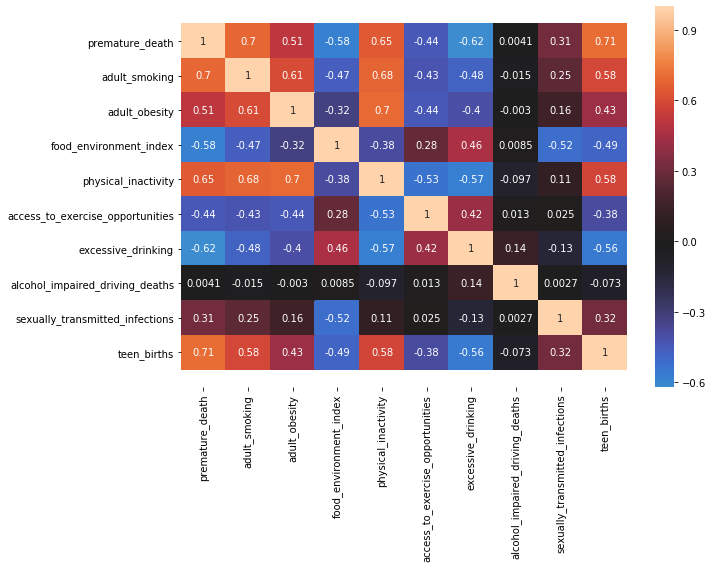

In [11]:
# plotting correlation heatmaps for each group of features along with the target
# as well as a heatmap of them all
fig, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(train[target_var+health_behaviors].corr(),
           center = 0, annot = True)
ax.set_ylim(len(target_var+health_behaviors)+0.5, -0.5);

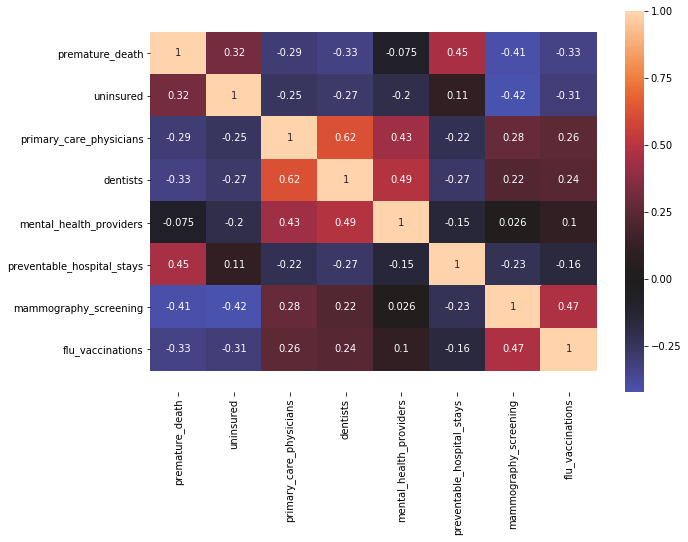

In [12]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(train[target_var+clinical_care].corr(),
           center = 0, annot = True)
ax.set_ylim(len(target_var+clinical_care)+0.5, -0.5);

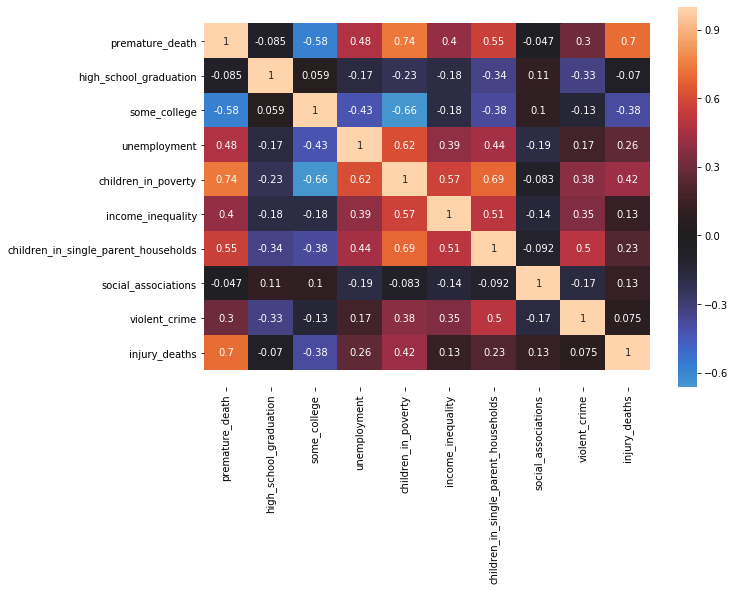

In [13]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(train[target_var+socio_econ_environ].corr(),
           center = 0, annot = True)
ax.set_ylim(len(target_var+socio_econ_environ)+0.5, -0.5);

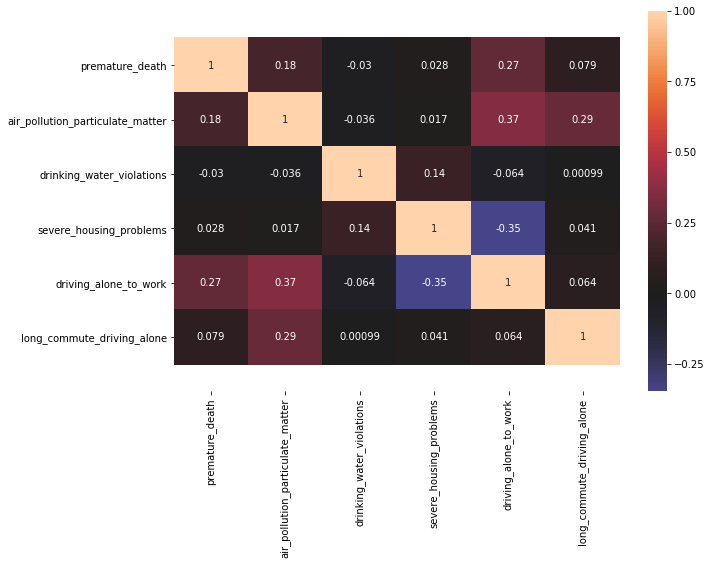

In [14]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(train[target_var+phys_environ].corr(),
           center = 0, annot = True)
ax.set_ylim(len(target_var+phys_environ)+0.5, -0.5);

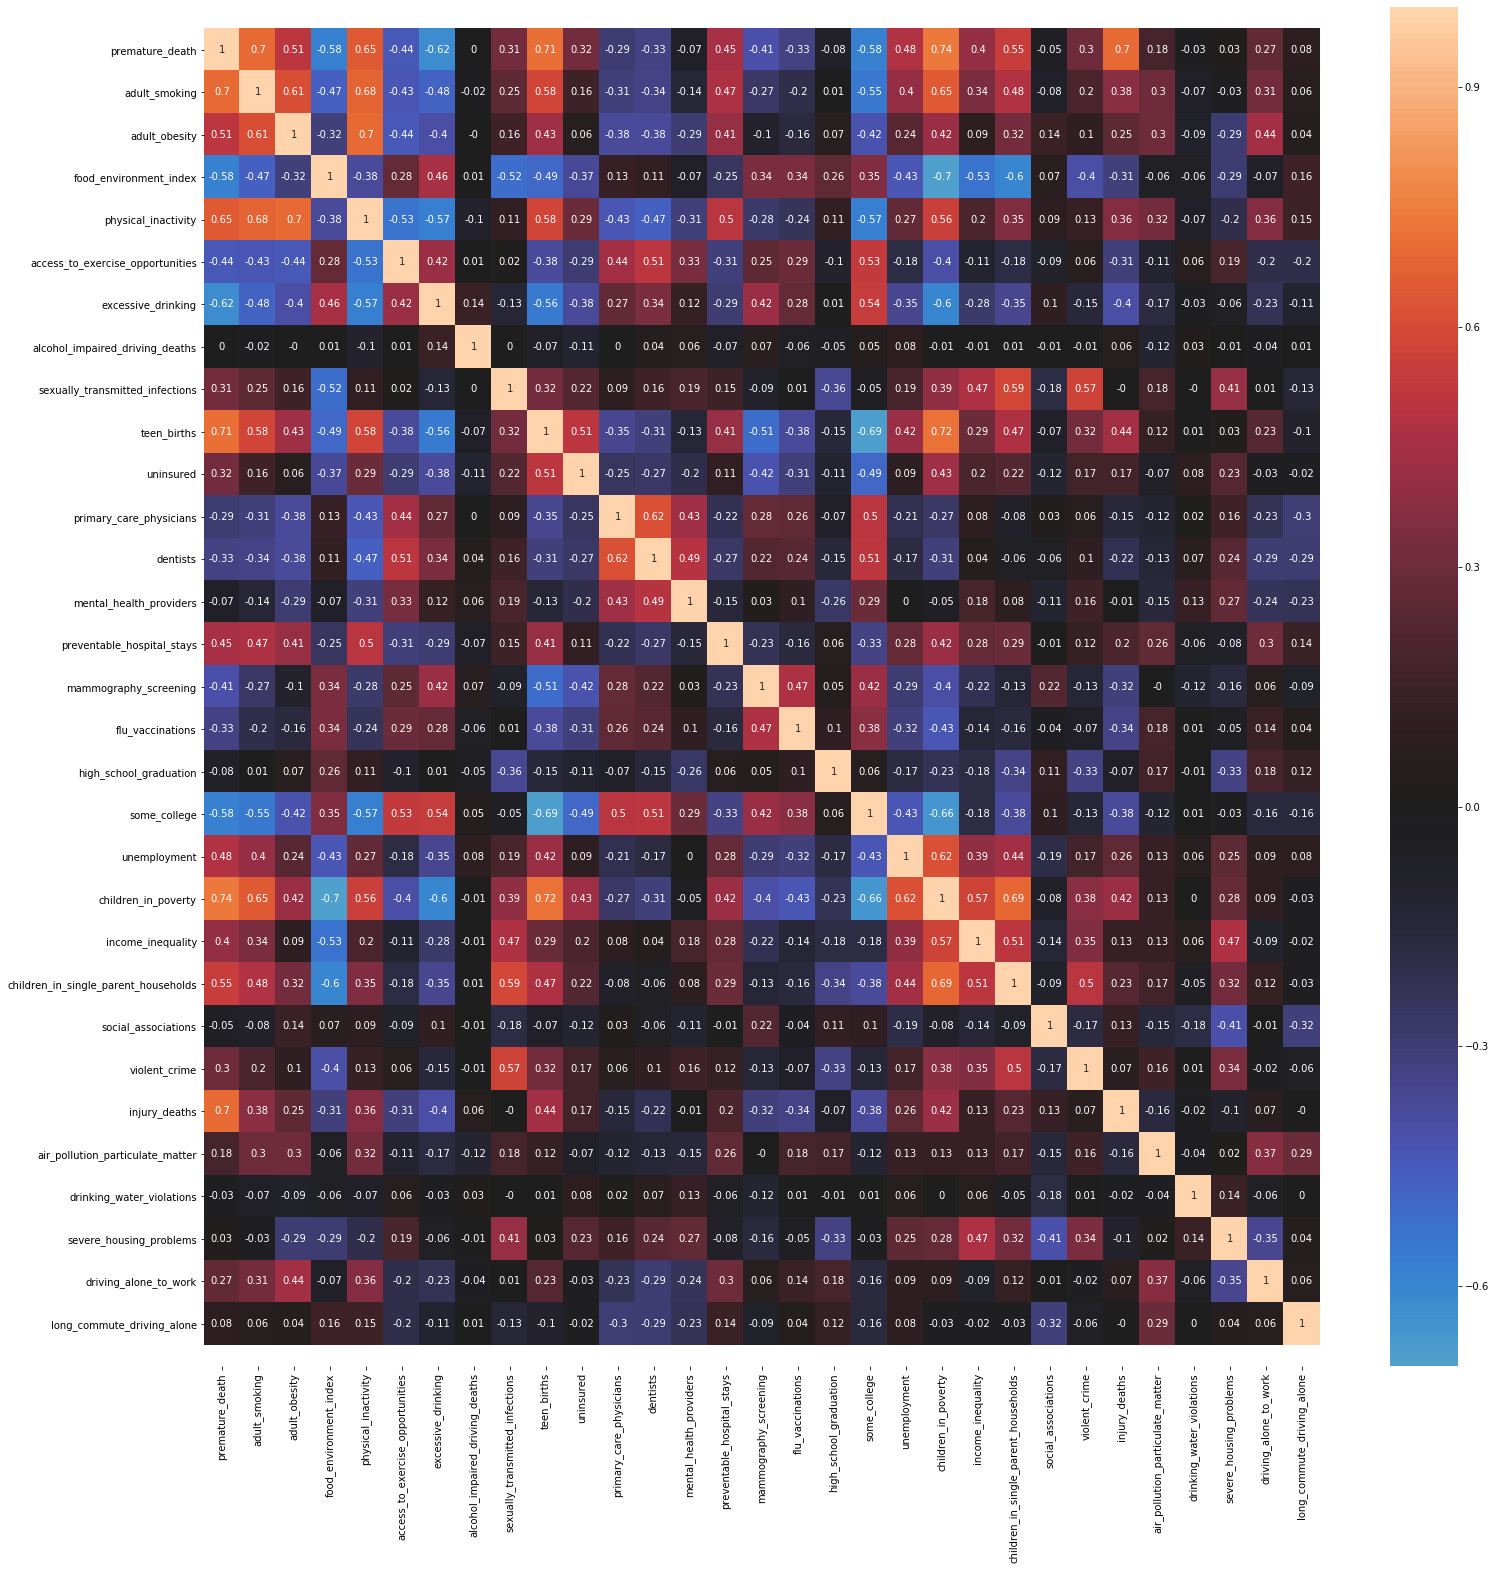

In [15]:
fig, ax = plt.subplots(figsize = (25, 25))
sns.heatmap(train[target_var+feature_vars].corr().round(2),
           center = 0, annot = True)
ax.set_ylim(len(target_var+feature_vars)+0.5, -0.5);

In [16]:
# a listing of all the correlations as absolute values
all_corr_df = train.corr()
all_corr_df.premature_death.abs().sort_values(ascending=False)

premature_death                         1.000000
children_in_poverty                     0.738289
teen_births                             0.707047
injury_deaths                           0.702457
adult_smoking                           0.695879
physical_inactivity                     0.647399
excessive_drinking                      0.620281
some_college                            0.582470
food_environment_index                  0.579951
children_in_single_parent_households    0.553102
adult_obesity                           0.512692
unemployment                            0.477808
preventable_hospital_stays              0.452075
access_to_exercise_opportunities        0.440789
mammography_screening                   0.407670
income_inequality                       0.399789
flu_vaccinations                        0.332465
dentists                                0.328641
uninsured                               0.321818
sexually_transmitted_infections         0.314778
violent_crime       

In [17]:
def variance_inflation_factor_printout(feature_list, df):
    feature_df = df[feature_list]
    vif = [variance_inflation_factor(feature_df.values, i) for i in range(feature_df.shape[1])]
    data = list(zip(feature_list, vif))
    data_df = pd.DataFrame(data, columns=['Feature','VIF'])
    return data_df

In [18]:
# evaluating collinearity to see if anything is highly collinear
# nothing is excessively collinear, 
# but children_in_poverty is worrying, and will be monitored
# the rule of thumb is to set a cutoff between 5 and 10
variance_inflation_factor_printout(feature_vars, train_std_df)

,Feature,VIF
0,adult_smoking,2.996356
1,adult_obesity,2.716229
2,food_environment_index,2.841101
3,physical_inactivity,3.634129
4,access_to_exercise_opportunities,1.896513
5,excessive_drinking,2.197167
6,alcohol_impaired_driving_deaths,1.098110
7,sexually_transmitted_infections,2.652813
8,teen_births,4.050128
9,uninsured,2.242929


In [19]:
# Implementing Lasso (L1) regression with the LARS algorithm
# for determing a best lambda (i.e. regularization rate)
# with BIC (Bayesian Information Criterion) as the metric to maximize
lars_model_bic = LassoLarsIC(criterion='bic')
lars_model_bic.fit(X_train_std_df, y_train_std_df['premature_death'])

lars_model_bic_rss = lars_model_bic.score(X_train_std_df,
                                          y_train_std_df['premature_death'])
lars_model_bic_results = ([lars_model_bic_rss]
                          +[lars_model_bic.intercept_]
                          +list(lars_model_bic.coef_))

lars_results_cols = ['rss', 'intercept']+feature_vars
lars_model_bic_dict = {'bic': lars_model_bic_results}
lars_model_bic_df = pd.DataFrame.from_dict(lars_model_bic_dict,
                                           orient="index",
                                           columns=lars_results_cols)

In [20]:
# exploring the dropped and retained features
lars_model_bic_df.iloc[0][lars_model_bic_df.iloc[0] == 0]

access_to_exercise_opportunities    0.0
alcohol_impaired_driving_deaths     0.0
uninsured                           0.0
primary_care_physicians             0.0
dentists                            0.0
mental_health_providers             0.0
mammography_screening               0.0
flu_vaccinations                    0.0
high_school_graduation              0.0
some_college                        0.0
social_associations                 0.0
violent_crime                       0.0
drinking_water_violations           0.0
severe_housing_problems             0.0
Name: bic, dtype: float64

In [21]:
bic_feats = list(lars_model_bic_df.iloc[0][lars_model_bic_df.iloc[0] != 0].index[2:])
lars_model_bic_df.iloc[0][lars_model_bic_df.iloc[0] != 0]

rss                                     8.421229e-01
intercept                               1.983143e-16
adult_smoking                           1.413753e-01
adult_obesity                           1.313729e-02
food_environment_index                 -5.664222e-02
physical_inactivity                     8.347467e-02
excessive_drinking                     -7.051567e-02
sexually_transmitted_infections         5.757046e-02
teen_births                             1.382624e-01
preventable_hospital_stays              2.415353e-02
unemployment                            2.224499e-02
children_in_poverty                     9.156557e-02
income_inequality                       3.350648e-02
children_in_single_parent_households    6.199350e-02
injury_deaths                           4.149087e-01
air_pollution_particulate_matter        3.974965e-02
driving_alone_to_work                   4.206169e-02
long_commute_driving_alone              3.698865e-02
Name: bic, dtype: float64

In [22]:
# Implementing Lasso (L1) regression with the LARS algorithm
# for determing a best lambda (i.e. regularization rate)
# with AIC (Akaike Information Criterion) as the metric to maximize
lars_model_aic = LassoLarsIC(criterion='aic')
lars_model_aic.fit(X_train_std_df, y_train_std_df['premature_death'])

lars_model_aic_rss = lars_model_aic.score(X_train_std_df,
                                          y_train_std_df['premature_death'])
lars_model_aic_results = ([lars_model_aic_rss]
                          +[lars_model_aic.intercept_]
                          +list(lars_model_aic.coef_))

lars_model_aic_dict = {'aic': lars_model_aic_results}
lars_model_aic_df = pd.DataFrame.from_dict(lars_model_aic_dict,
                                           orient="index",
                                           columns=lars_results_cols)

In [23]:
# exploring the dropped and retained features
lars_model_aic_df.iloc[0][lars_model_aic_df.iloc[0] == 0]

access_to_exercise_opportunities    0.0
alcohol_impaired_driving_deaths     0.0
uninsured                           0.0
primary_care_physicians             0.0
dentists                            0.0
mental_health_providers             0.0
mammography_screening               0.0
flu_vaccinations                    0.0
high_school_graduation              0.0
some_college                        0.0
social_associations                 0.0
drinking_water_violations           0.0
severe_housing_problems             0.0
Name: aic, dtype: float64

In [24]:
aic_feats = list(lars_model_aic_df.iloc[0][lars_model_aic_df.iloc[0] != 0].index[2:])
lars_model_aic_df.iloc[0][lars_model_aic_df.iloc[0] != 0]

rss                                     8.442411e-01
intercept                               2.156315e-16
adult_smoking                           1.389440e-01
adult_obesity                           1.655846e-02
food_environment_index                 -5.914359e-02
physical_inactivity                     8.163027e-02
excessive_drinking                     -7.139632e-02
sexually_transmitted_infections         6.196648e-02
teen_births                             1.407006e-01
preventable_hospital_stays              2.557862e-02
unemployment                            2.591905e-02
children_in_poverty                     8.476966e-02
income_inequality                       3.870894e-02
children_in_single_parent_households    6.057828e-02
violent_crime                           4.308235e-03
injury_deaths                           4.226804e-01
air_pollution_particulate_matter        4.260132e-02
driving_alone_to_work                   4.764841e-02
long_commute_driving_alone              4.5011

In [25]:
# Collinearity has decreased, but children_in
variance_inflation_factor_printout(bic_feats, train_std_df)

,Feature,VIF
0,adult_smoking,2.640083
1,adult_obesity,2.347140
2,food_environment_index,2.539830
3,physical_inactivity,3.314849
4,excessive_drinking,2.013996
5,sexually_transmitted_infections,2.086921
6,teen_births,2.778462
7,preventable_hospital_stays,1.541753
8,unemployment,1.729444
9,children_in_poverty,5.724357


In [26]:
# implementing a regression with the features remaining
# when BIC is minimized to further evaluate against 
# when AIC is minimized
X_train_bic_cols = '+'.join(bic_feats)
formula_bic = target_var[0] + '~' + X_train_bic_cols
model_bic = ols(formula=formula_bic,
                data=train_std_df[target_var+bic_feats])
results_bic = model_bic.fit()
results_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     676.1
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:33:37   Log-Likelihood:                -952.97
No. Observations:                1978   AIC:                             1940.
Df Residuals:                    1961   BIC:                             2035.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             1.845e-16      0.009   2.09e-14      1.000      -0.017       0.017
adult_smoking                            0.1308      0.014      9.101      0.000       0.103       0.159
adult_obesity                            0.0250      0.014      1.844      0.065      -0.002       0.052
food_environment_index                  -0.0672      0.014     -4.770      0.000      -0.095      -0.040
physical_inactivity                      0.0765      0.016      4.747      0.000       0.045       0.108
excessive_drinking                      -0.0729      0.013     -5.805      0.000      -0.098      -0.048
sexually_transmitted_infections          0.0797      0.013      6.239      0.000       0.055       0.105
teen_births                              0.1497      0.015     10.155      0.000       0.121       0.179
preventable_hospital_stays               0.0291      0.011      2.648      0.008       0.008       0.051
unemployment                             0.0346      0.012      2.976      0.003       0.012       0.057
children_in_poverty                      0.0674      0.021      3.185      0.001       0.026       0.109
income_inequality                        0.0532      0.012      4.333      0.000       0.029       0.077
children_in_single_parent_households     0.0603      0.014      4.211      0.000       0.032       0.088
injury_deaths                            0.4444      0.011     40.715      0.000       0.423       0.466
air_pollution_particulate_matter         0.0524      0.011      4.745      0.000       0.031       0.074
driving_alone_to_work                    0.0620      0.011      5.747      0.000       0.041       0.083
long_commute_driving_alone               0.0673      0.010      6.703      0.000       0.048       0.087
==============================================================================
Omnibus:                      166.567   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              451.896
Skew:                           0.458   Prob(JB):                     7.45e-99
Kurtosis:                       5.155   Cond. No.                         6.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# implementing a regression with the features remaining
# when AIC is minimized to further evaluate against 
# when BIC is minimized
X_train_aic_cols = '+'.join(aic_feats)
formula_aic = target_var[0] + '~' + X_train_aic_cols
model_aic = ols(formula=formula_aic,
                data=train_std_df[target_var+aic_feats])
results_aic = model_aic.fit()
results_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     636.8
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:33:37   Log-Likelihood:                -951.96
No. Observations:                1978   AIC:                             1940.
Df Residuals:                    1960   BIC:                             2041.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             1.845e-16      0.009   2.09e-14      1.000      -0.017       0.017
adult_smoking                            0.1323      0.014      9.182      0.000       0.104       0.161
adult_obesity                            0.0259      0.014      1.912      0.056      -0.001       0.053
food_environment_index                  -0.0660      0.014     -4.673      0.000      -0.094      -0.038
physical_inactivity                      0.0766      0.016      4.756      0.000       0.045       0.108
excessive_drinking                      -0.0738      0.013     -5.873      0.000      -0.098      -0.049
sexually_transmitted_infections          0.0740      0.013      5.522      0.000       0.048       0.100
teen_births                              0.1474      0.015      9.934      0.000       0.118       0.176
preventable_hospital_stays               0.0295      0.011      2.684      0.007       0.008       0.051
unemployment                             0.0360      0.012      3.083      0.002       0.013       0.059
children_in_poverty                      0.0661      0.021      3.123      0.002       0.025       0.108
income_inequality                        0.0530      0.012      4.312      0.000       0.029       0.077
children_in_single_parent_households     0.0567      0.015      3.900      0.000       0.028       0.085
violent_crime                            0.0161      0.011      1.412      0.158      -0.006       0.038
injury_deaths                            0.4440      0.011     40.668      0.000       0.423       0.465
air_pollution_particulate_matter         0.0504      0.011      4.532      0.000       0.029       0.072
driving_alone_to_work                    0.0630      0.011      5.823      0.000       0.042       0.084
long_commute_driving_alone               0.0670      0.010      6.675      0.000       0.047       0.087
==============================================================================
Omnibus:                      170.136   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              462.853
Skew:                           0.468   Prob(JB):                    3.11e-101
Kurtosis:                       5.177   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# The features that maximize BIC produced essentially the same result with one fewer feature,
# and will therefore be proceeded with

In [29]:
# dropping 'adult_obesity' because it was the only feature with a p_value above 0.05
adj_bic_feats = [bic_feats[0]]+bic_feats[2:]

In [30]:
# testing how removing obesity impacts the model
X_train_adj_bic_cols = '+'.join(adj_bic_feats)
formula_adj_bic = target_var[0] + '~' + X_train_adj_bic_cols
model_adj_bic = ols(formula=formula_adj_bic,
                    data=train_std_df[target_var+adj_bic_feats])
results_adj_bic = model_adj_bic.fit()
results_adj_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     720.1
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:33:37   Log-Likelihood:                -954.68
No. Observations:                1978   AIC:                             1941.
Df Residuals:                    1962   BIC:                             2031.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             1.845e-16      0.009   2.08e-14      1.000      -0.017       0.017
adult_smoking                            0.1367      0.014      9.742      0.000       0.109       0.164
food_environment_index                  -0.0679      0.014     -4.816      0.000      -0.096      -0.040
physical_inactivity                      0.0891      0.015      6.118      0.000       0.061       0.118
excessive_drinking                      -0.0730      0.013     -5.813      0.000      -0.098      -0.048
sexually_transmitted_infections          0.0819      0.013      6.428      0.000       0.057       0.107
teen_births                              0.1476      0.015     10.034      0.000       0.119       0.176
preventable_hospital_stays               0.0302      0.011      2.749      0.006       0.009       0.052
unemployment                             0.0355      0.012      3.053      0.002       0.013       0.058
children_in_poverty                      0.0672      0.021      3.172      0.002       0.026       0.109
income_inequality                        0.0497      0.012      4.095      0.000       0.026       0.074
children_in_single_parent_households     0.0612      0.014      4.275      0.000       0.033       0.089
injury_deaths                            0.4441      0.011     40.665      0.000       0.423       0.465
air_pollution_particulate_matter         0.0525      0.011      4.753      0.000       0.031       0.074
driving_alone_to_work                    0.0663      0.011      6.278      0.000       0.046       0.087
long_commute_driving_alone               0.0657      0.010      6.565      0.000       0.046       0.085
==============================================================================
Omnibus:                      166.777   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              451.869
Skew:                           0.459   Prob(JB):                     7.55e-99
Kurtosis:                       5.154   Cond. No.                         6.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# minimal impact on model performance when adult_obesity is removed,
# so it will be removed from the features

In [32]:
# Collinearity has reduced, but children_in_poverty is still a little high
variance_inflation_factor_printout(adj_bic_feats, train_std_df)

,Feature,VIF
0,adult_smoking,2.511788
1,food_environment_index,2.538166
2,physical_inactivity,2.709817
3,excessive_drinking,2.013923
4,sexually_transmitted_infections,2.070006
5,teen_births,2.761052
6,preventable_hospital_stays,1.537365
7,unemployment,1.726457
8,children_in_poverty,5.724133
9,income_inequality,1.882313


In [33]:
# dropping 'children_in_poverty'
# because it was the only feature with a variance inflation factor above 5
further_adj_bic_feats = [bic_feats[0]]+bic_feats[2:9]+bic_feats[10:]

In [34]:
further_adj_bic_feats

['adult_smoking',
 'food_environment_index',
 'physical_inactivity',
 'excessive_drinking',
 'sexually_transmitted_infections',
 'teen_births',
 'preventable_hospital_stays',
 'unemployment',
 'income_inequality',
 'children_in_single_parent_households',
 'injury_deaths',
 'air_pollution_particulate_matter',
 'driving_alone_to_work',
 'long_commute_driving_alone']

In [35]:
# testing how removing child poverty impacts the model
X_train_further_adj_bic_cols = '+'.join(further_adj_bic_feats)
formula_further_adj_bic = target_var[0] + '~' + X_train_further_adj_bic_cols
model_further_adj_bic = ols(formula=formula_further_adj_bic,
                            data=train_std_df[target_var+further_adj_bic_feats])
results_further_adj_bic = model_further_adj_bic.fit()
results_further_adj_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     767.2
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:33:38   Log-Likelihood:                -959.74
No. Observations:                1978   AIC:                             1949.
Df Residuals:                    1963   BIC:                             2033.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             1.845e-16      0.009   2.08e-14      1.000      -0.017       0.017
adult_smoking                            0.1440      0.014     10.382      0.000       0.117       0.171
food_environment_index                  -0.0797      0.014     -5.851      0.000      -0.106      -0.053
physical_inactivity                      0.0937      0.015      6.444      0.000       0.065       0.122
excessive_drinking                      -0.0806      0.012     -6.515      0.000      -0.105      -0.056
sexually_transmitted_infections          0.0766      0.013      6.052      0.000       0.052       0.101
teen_births                              0.1652      0.014     12.100      0.000       0.138       0.192
preventable_hospital_stays               0.0320      0.011      2.909      0.004       0.010       0.054
unemployment                             0.0473      0.011      4.286      0.000       0.026       0.069
income_inequality                        0.0595      0.012      5.058      0.000       0.036       0.083
children_in_single_parent_households     0.0776      0.013      5.802      0.000       0.051       0.104
injury_deaths                            0.4455      0.011     40.735      0.000       0.424       0.467
air_pollution_particulate_matter         0.0510      0.011      4.612      0.000       0.029       0.073
driving_alone_to_work                    0.0601      0.010      5.779      0.000       0.040       0.080
long_commute_driving_alone               0.0650      0.010      6.486      0.000       0.045       0.085
==============================================================================
Omnibus:                      169.576   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              438.860
Skew:                           0.482   Prob(JB):                     5.04e-96
Kurtosis:                       5.097   Cond. No.                         4.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
##### Discuss implementing this with Brad #####
##### It actually seems like it makes the residuals less normal #####
variance_inflation_factor_printout(further_adj_bic_feats, train_std_df)

,Feature,VIF
0,adult_smoking,2.443598
1,food_environment_index,2.360464
2,physical_inactivity,2.683873
3,excessive_drinking,1.941984
4,sexually_transmitted_infections,2.034789
5,teen_births,2.367924
6,preventable_hospital_stays,1.533292
7,unemployment,1.549301
8,income_inequality,1.760279
9,children_in_single_parent_households,2.274059


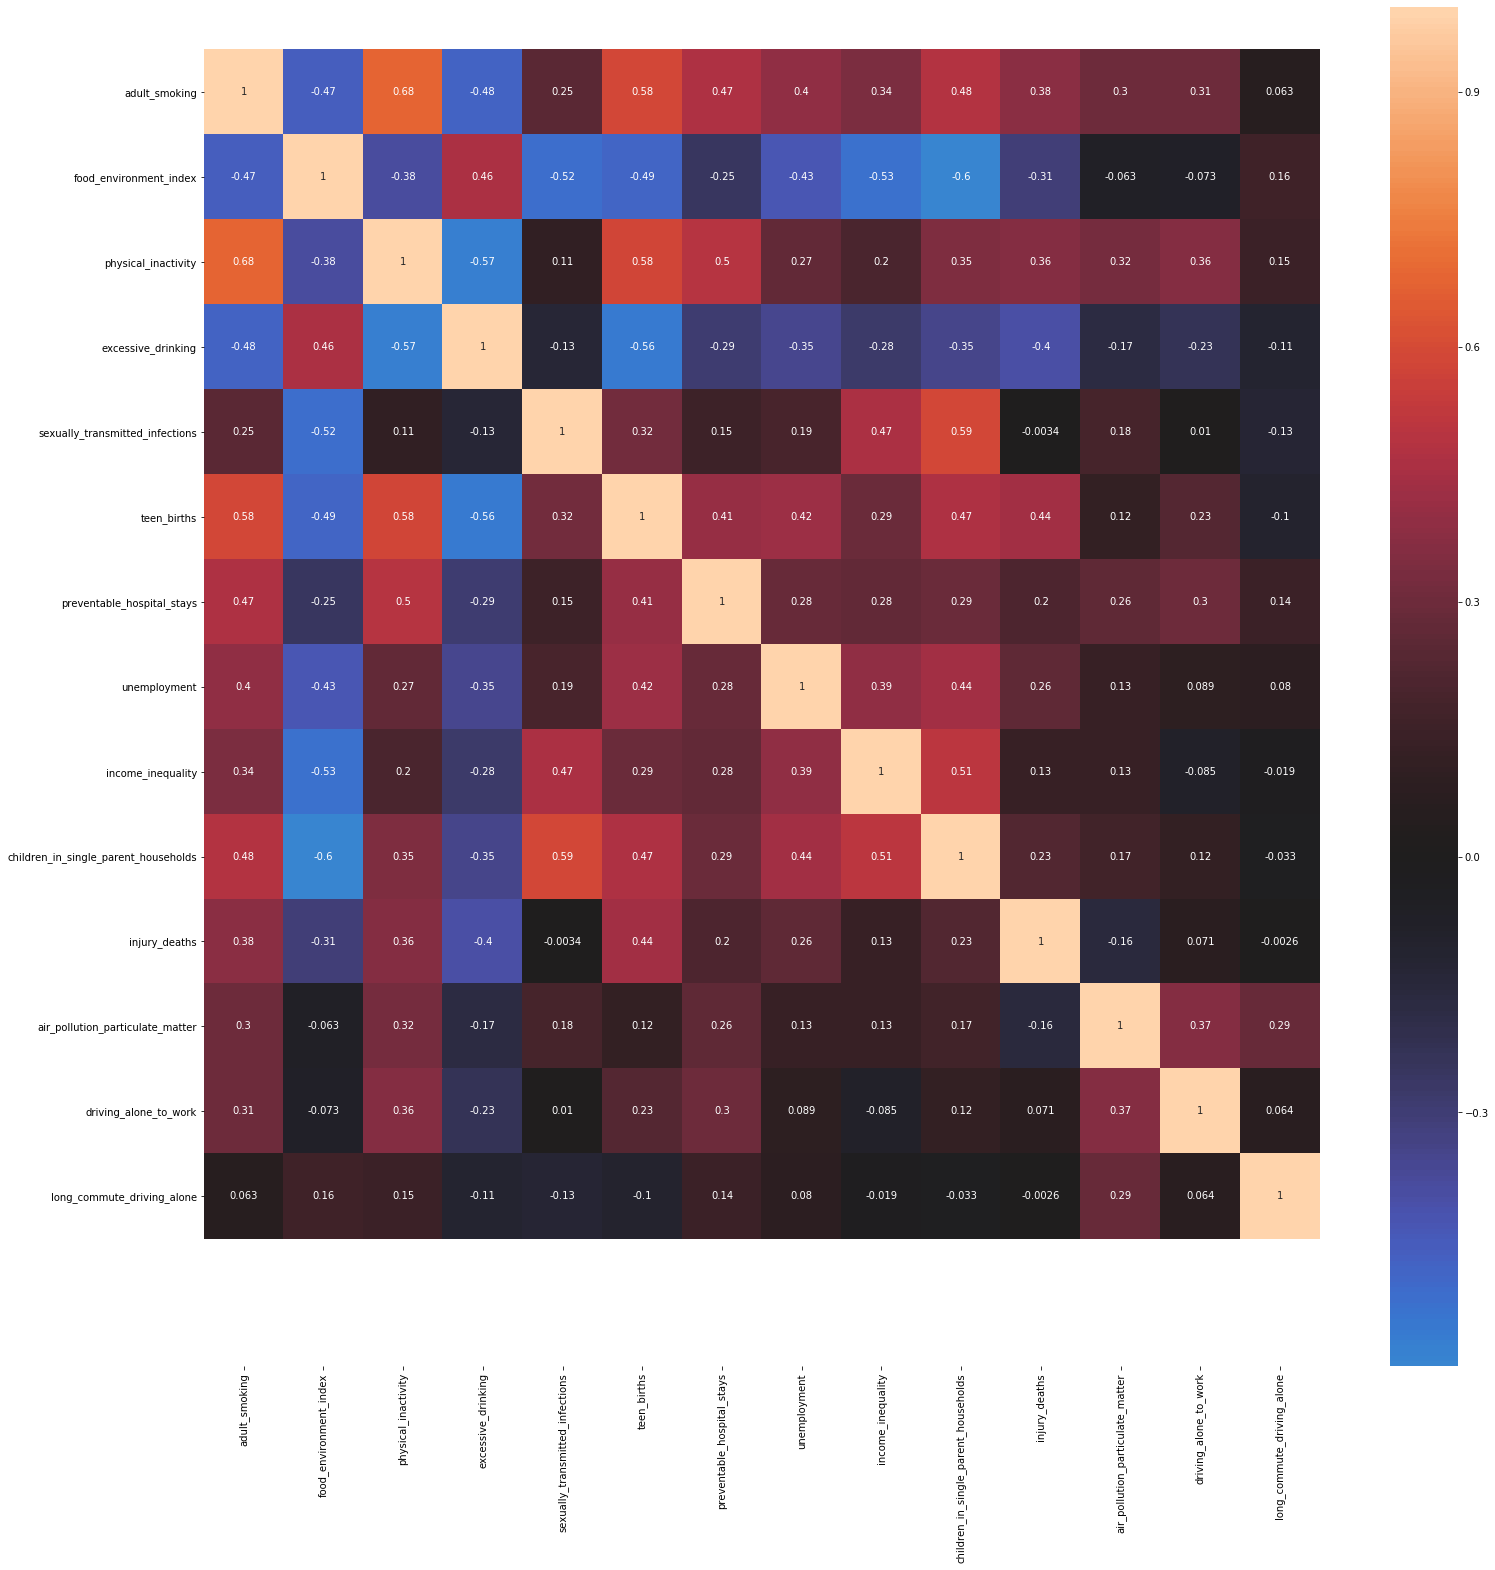

In [56]:
##### discuss with brad, nothing too correlated with each other #####
fig, ax = plt.subplots(figsize = (25, 25))
sns.heatmap(train_std_df[further_adj_bic_feats].corr(),
            center = 0, annot = True)
ax.set_ylim(len(target_var+further_adj_bic_feats)+0.5, -0.5);

In [37]:
##### decide if I want to keep, and remove redundant pip definition from above #####
pipe = Pipeline([
   ('sc', StandardScaler()),
   ('lr', LinearRegression())])
adj_bic_cvs = cross_val_score(pipe, X_train[adj_bic_feats], y_train, cv=10)
print(np.mean(adj_bic_cvs))
print(np.std(adj_bic_cvs))

0.8424046776154575
0.020633882545935997


In [38]:
adj_bic_cvs = cross_val_score(pipe, X_train[further_adj_bic_feats], y_train, cv=10)
print(np.mean(adj_bic_cvs))
print(np.std(adj_bic_cvs))

0.8417474397382645
0.02028701941868296


In [39]:
bic_cvs = cross_val_score(pipe, X_train[bic_feats], y_train, cv=10)
print(np.mean(bic_cvs))
print(np.std(bic_cvs))

0.8426192893101406
0.020765667629039666


Choosing the results of the bic based LassoLARS because it produced the same results as the aic based model, but with one fewer feature. Similarly adult obesity was removed because it was the only remaining feature with a p-value above 0.05, and upon its removal the BIC dropped slightly and the R-squared values were negligibly affected.

In [40]:
final_features = adj_bic_feats

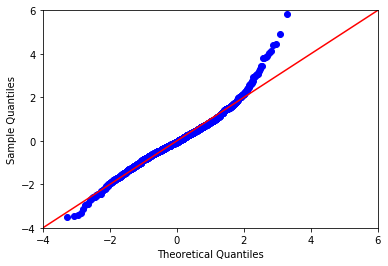

In [41]:
sm.graphics.qqplot(results_adj_bic.resid, dist=stats.norm, line='45', fit=True)
plt.ylim(-4,6)
plt.xlim(-4,6);

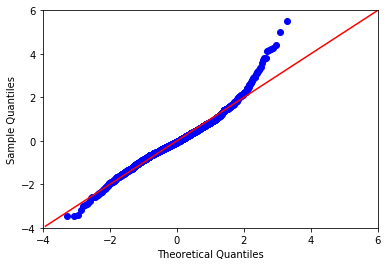

In [42]:
sm.graphics.qqplot(results_further_adj_bic.resid, dist=stats.norm, line='45', fit=True)
plt.ylim(-4,6)
plt.xlim(-4,6);

In [43]:
## Generating and saving a qqplot to evaluate the Homoscedasticity assumption
##### add further interpretive comments #####
# sm.graphics.qqplot(results_adj_bic.resid, dist=stats.norm, line='45', fit=True)
# plt.title("Deviation of Residuals (blue) from Normality (red)")
# plt.savefig('normality_qqplot.png')
# plt.show();

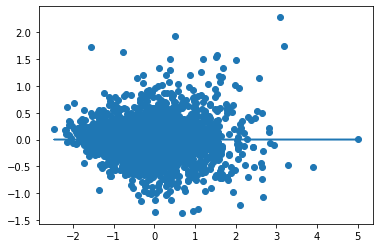

In [53]:
##### add further interpretive comments #####
plt.scatter(results_adj_bic.predict(X_train_std_df[final_features]), results_adj_bic.resid)
plt.plot(results_adj_bic.predict(X_train_std_df[final_features]), [0 for i in range(len(train))]);

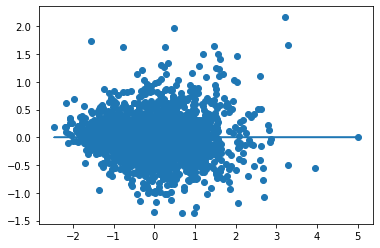

In [54]:
##### add further interpretive comments #####
plt.scatter(results_further_adj_bic.predict(X_train_std_df[final_features]), results_further_adj_bic.resid)
plt.plot(results_further_adj_bic.predict(X_train_std_df[final_features]), [0 for i in range(len(train))]);

In [45]:
## Generating and saving a residuals plot to evaluate the Homoscedasticity assumption
# plt.scatter(results_adj_bic.predict(X_train_std_df[final_features]), results_adj_bic.resid)
# plt.plot(results_adj_bic.predict(X_train_std_df[final_features]), [0 for i in range(len(train))])
# plt.title("Variance of Residuals")
# plt.xlabel('Predicted Values')
# plt.ylabel('Residual Error')
# plt.savefig('residuals_variance.png')
# plt.show();

In [46]:
##### Finish annotating below #####

In [47]:
test_predictions = results_adj_bic.predict(X_test_std_df[final_features])

In [48]:
r2_score(y_test_std_df['premature_death'],test_predictions)

0.8406518192173286

In [49]:
mean_squared_error(y_test_std_df['premature_death'], test_predictions)

0.1593481807826714

In [50]:
results_adj_bic.rsquared_adj

0.8450982706925265

In [51]:
results_adj_bic.mse_resid

0.1549800812191111

In [ ]:
##### with further adjusted #####

In [57]:
further_adj_test_predictions = results_further_adj_bic.predict(X_test_std_df[further_adj_bic_feats])

In [58]:
r2_score(y_test_std_df['premature_death'],further_adj_test_predictions)

0.8374583723107843

In [59]:
mean_squared_error(y_test_std_df['premature_death'], further_adj_test_predictions)

0.16254162768921565

In [60]:
results_further_adj_bic.rsquared_adj

0.8443832345461626

In [61]:
results_further_adj_bic.mse_resid

0.15569547904283776